# Data Wrangling for [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)

---

## Hypothesis Generation

To solve any analytics problems, list down a set of hypothesis. In this case, they are factors that will affect the cost of a taxi trip:

- Trip distance affects the price;
- Traffic hours might affect the price;
- Number of drivers available might affect the price;
- Weekdays VS weekends, affects the price;
- Late night hours might affect the price;
- Certain pickup or drop-off locations might affect the price;

## 1. Load Datasets

In [1]:
import math
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import subprocess
import seaborn as sns
sns.set()

import time
start_time = time.time()

In [2]:
# LARGE CSV LOAD and FAST: https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows
# def file_len(fname):
#     p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     result, err = p.communicate()
#     if p.returncode != 0:
#         raise IOError(err)
#     return int(result.strip().split()[0])+1

# train_rows = file_len('data/train.csv')  # 55423857
train_rows = 55423857
print (f'>>> Exact number of rows: {train_rows}')

test_df = pd.read_csv('data/test.csv')
submission_df = pd.read_csv('data/sample_submission.csv')

try:
    train_df = pd.read_csv('data/train.csv', nrows=5)
except FileNotFoundError:
    print('>>> You must download train.csv from: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/download/train.csv')

>>> Exact number of rows: 55423857


### Tricks to decrease memory footprint

We might not need float64 (16 decimal places) for the longitude and latitude values. float32 (7 decimal places) might be just enough:

In [3]:
# set column types to optimize memory usage
col_types = {
    'fare_amount': 'float32',
    'pickup_datetime': 'str', 
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

new_cols = list(col_types.keys())

read_size = 5000000 # 5M
train_df = pd.DataFrame()

Alternative #1: read the entire DataFrame from the disk

In [4]:
# %%time

# df_list = [] # list to hold the batch dataframe

# for df_chunk in tqdm(pd.read_csv('data/train.csv', usecols=new_cols, dtype=col_types, chunksize=read_size)):
#     df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
#     df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
#     # Can process each chunk of dataframe here
#     # clean_data(), feature_engineer(),fit()
    
#     # Alternatively, append the chunk to list and merge all
#     df_list.append(df_chunk) 
        
# # merge all dataframes into one
# train_df = pd.concat(df_list)
# del df_list

Alternative #2: read the data partially

In [5]:
%%time

if (train_df.empty):
    train_df = pd.read_csv('data/train.csv', usecols=new_cols, dtype=col_types, nrows=read_size)
    train_df['pickup_datetime'] = train_df['pickup_datetime'].str.slice(0, 16)
    train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

Wall time: 9.3 s


In [6]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 138.3 MB


## 2. Data Cleaning

In [7]:
# Convert to DateTime
# train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

In [8]:
# check feature statistics
pd.set_option('float_format', '{:f}'.format) # prints the entire number instead of x + ye
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5000000.000000,5000000.000000,5000000.000000,4999964.000000,4999964.000000,5000000.000000
mean,11.320350,-71.286377,41.739189,-71.286263,41.736210,1.684695
std,9.775069,12.638400,9.093792,12.685239,9.608747,1.331854
min,-100.000000,-3426.608887,-3488.079590,-3412.653076,-3488.079590,0.000000
25%,6.000000,-73.992065,40.734909,-73.991394,40.734043,1.000000
50%,8.500000,-73.981812,40.752636,-73.980156,40.753151,1.000000
75%,12.500000,-73.967110,40.767117,-73.963669,40.768108,2.000000
max,1273.310059,3439.425537,3310.364502,3457.622314,3345.917236,208.000000


In [9]:
# Check missing data
print(train_df.isnull().sum())

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    36
dropoff_latitude     36
passenger_count       0
dtype: int64


In [10]:
# Checks numeric columns for negative numbers
def check_numeric(df):     
    neg_count_df = pd.DataFrame(columns=['Negative values count'])
    
    #print('>>> Number of negative values found in numeric columns:')
    num_col_list = list(df.select_dtypes(include=['uint8', 'float32']).columns)    
    
    total_neg = 0
    for col_name in num_col_list:
        neg_count = df[df[col_name] < 0].shape[0]  # extract number of rows        
        #print('\t*' + col_name+ '* = ' + str(neg_count))
        neg_count_df.loc[col_name] = neg_count
        total_neg += neg_count
    
    return neg_count_df, total_neg


# count how many negative values are there
neg_count_df, total_neg_count = check_numeric(train_df)
display(neg_count_df)

,Negative values count
fare_amount,211
pickup_longitude,4902075
pickup_latitude,2599
dropoff_longitude,4902187
dropoff_latitude,2615
passenger_count,0


In [11]:
# Remove NaNs and Negative & Free fares (keeping only the ones that cost more than 0)
train_df.dropna(inplace=True, axis=0)
train_df = train_df[train_df['fare_amount'] > 0]

In [12]:
# Remove rows where lat/long are ZERO
print('>>> Original shape:', train_df.shape)
print('>>> Lat/Long == 0 :', train_df[(train_df.pickup_latitude==0) | (train_df.pickup_longitude)==0 | (train_df.dropoff_latitude==0)|(train_df.dropoff_longitude==0)].shape)

train_df = train_df[(train_df['pickup_latitude'] != 0) & (train_df['pickup_longitude'] != 0)]
train_df = train_df[(train_df['dropoff_latitude'] != 0) & (train_df['dropoff_longitude'] != 0)]
print('>>> After:         ', train_df.shape)

>>> Original shape: (4999621, 7)
>>> Lat/Long == 0 : (95271, 7)
>>> After:          (4899927, 7)


In [13]:
# Handle rides with too many or too few passengers
print(train_df.loc[train_df.passenger_count < 0].shape)
print(train_df.loc[train_df.passenger_count == 0].shape)
print(train_df.loc[train_df.passenger_count > 6].shape)

# Update values based on comparison
# train_df.loc[train_df['passenger_count'] == 0, 'passenger_count'] = 1
# train_df.loc[train_df['passenger_count'] > 6, 'passenger_count'] = 6
train_df = train_df[(train_df['passenger_count'] > 0) & (train_df['passenger_count'] <= 7)]

(0, 7)
(17216, 7)
(6, 7)


In [14]:
print(train_df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4882706 entries, 0 to 4999999
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 172.3 MB
None


## 3. Preliminary EDA

### Distribution of fare amount

In [15]:
# plt.figure(figsize=(10,6))
# sns.kdeplot(train_df['fare_amount']).set_title("Distribution of Trip Fare")
# plt.show()

Since we saw above that fare amount is highly skewed,let us take log transformation of the fare amount and plot the distribution:

In [16]:
# plt.figure(figsize=(10,6))
# sns.kdeplot(np.log(train_df['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")
# plt.show()

In [17]:
# plt.figure(figsize=(10,6))

# plt.scatter(x=train_df['passenger_count'], y=train_df['fare_amount'])
# plt.xlabel("Number of Passengers")
# plt.ylabel("Fare Amount")
# plt.title("Passengers vs Fare Amount")
# plt.show()

### Distribution of Geographical Features

In [18]:
# city_long_border = (-74.03, -73.75)
# city_lat_border = (40.63, 40.85)

# plt.figure(figsize=(14,8))
# train_df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', color='green', s=.02, alpha=.6, ax=plt.gca())
# plt.title("Pickup Locations")
# plt.ylim(city_lat_border)
# plt.xlim(city_long_border)
# plt.show()

In [19]:
# plt.figure(figsize=(14,8))
# train_df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', color='red', s=.02, alpha=.6, ax=plt.gca())
# plt.title("Drop-off Locations")
# plt.ylim(city_lat_border)
# plt.xlim(city_long_border)
# plt.show()

### Distribution of passenger count

In [20]:
# plt.figure(figsize=(14,8))
# sns.kdeplot(train_df['passenger_count']).set_title("Distribution of Passengers")
# plt.show()

### Most common pickup/drop-off locations

In [21]:
# DEBUG TOP 5
# print('>>> Pickup latitude:')
# display(train_df['pickup_latitude'].value_counts().head())
# print('\n>>> Pickup longitude:')
# display(train_df['pickup_longitude'].value_counts().head())

# Identify the most frequently used locations
# top5_pickup = train_df.groupby(["pickup_latitude", "pickup_longitude"]).size().reset_index(name="FreqCount").sort_values(by='FreqCount', ascending=False).head(10)
# top5_pickup = top5_pickup[["pickup_latitude", "pickup_longitude"]]
# top5_dropoff = train_df.groupby(["dropoff_latitude", "dropoff_longitude"]).size().reset_index(name="FreqCount").sort_values(by='FreqCount', ascending=False).head(10)
# top5_dropoff = top5_dropoff[["dropoff_latitude", "dropoff_longitude"]]

# display(top5_pickup)
# display(top5_dropoff)

# 4. Feature Engineering


In [22]:
# Distance formula: https://www.movable-type.co.uk/scripts/latlong.html
def getDistance(lat1, lon1, lat2, lon2): 
    R = 6371e3
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    deltaPhi = math.radians(lat2-lat1)
    deltaLambda = math.radians(lon2-lon1)

    a = math.sin(deltaPhi/2) * math.sin(deltaPhi/2) + math.cos(phi1) * math.cos(phi2) * math.sin(deltaLambda/2) * math.sin(deltaLambda/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return round((R * c) / 1000, 3)    # returns distance in km

In [23]:
train_df['year'] = train_df.pickup_datetime.apply(lambda x: x.year)
train_df['month'] = train_df.pickup_datetime.apply(lambda x: x.month)
train_df['day'] = train_df.pickup_datetime.apply(lambda x: x.day)
train_df['hour'] = train_df.pickup_datetime.apply(lambda x: x.hour)
train_df['day_of_week'] = train_df.pickup_datetime.apply(lambda x: x.weekday())

train_df['year'] = train_df['year'].astype('int16')
train_df['month'] = train_df['month'].astype('int8')
train_df['day'] = train_df['day'].astype('int8')
train_df['hour'] = train_df['hour'].astype('int8')
train_df['day_of_week'] = train_df['day_of_week'].astype('int8')

In [24]:
# train_df['night'] = train_df.hour.apply(lambda x: 1 if ((x >= 21 and x <= 23) or (x >= 0 and x <= 5)) else 0)
# train_df['night'] = train_df['night'].astype('bool')

In [45]:
# train_df['peak_hour'] = train_df.hour.apply(lambda x: 1 if ((x >= 7 and x <= 9) or (x >= 16 and x <= 18)) else 0)
# train_df['peak_hour'] = train_df['peak_hour'].astype('bool')

In [26]:
train_df['distance_km'] = train_df.apply(lambda row: getDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
train_df['distance_km'] = train_df['distance_km'].astype('float32')

train_df['distance_km_round'] = train_df.distance_km.apply(lambda x: int(round(x)))
train_df['distance_km_round'] = train_df['distance_km_round'].astype('int16')

In [27]:
# from pandas.tseries.holiday import USFederalHolidayCalendar

# holidays = USFederalHolidayCalendar().holidays(start='2009-01-01', end='2015-12-31').to_pydatetime()
# train_df['holiday'] = train_df.pickup_datetime.apply(lambda x: 1 if x in holidays else 0)
# train_df['holiday'] = train_df['holiday'].astype('int8')

In [28]:
def add_taxis_per_hour(df):
    tmp = df.groupby(['year','month','day']).agg({'hour' : [np.size]}).reset_index()
    tmp.columns = ['year','month','day','taxis_per_hour']
    df = pd.merge(df, tmp, how='left', on=['year','month','day'])
    df['taxis_per_hour'] = df['taxis_per_hour'].astype('float32')
    return df

train_df = add_taxis_per_hour(train_df)

In [29]:
# Add mean and median FARE
tmp = train_df.groupby(['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'fare_amount' : [np.mean,np.median,np.min,np.max]}).reset_index()
tmp.columns = ['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
train_df = pd.merge(train_df, tmp, how='left', on=['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']) 

In [30]:
# Add mean and median DISTANCE
# tmp = train_df.groupby(['day_of_week','hour','mean_fare']).agg({'distance_km' : [np.mean,np.median]}).reset_index()
# tmp.columns = ['day_of_week','hour','mean_fare','distance_km_mean','distance_km_median']
# train_df = pd.merge(train_df, tmp, how='left', on=['day_of_week','hour','mean_fare']) 

# train_df['distance_km_mean'] = train_df['distance_km_mean'].astype('float32')
# train_df['distance_km_median'] = train_df['distance_km_median'].astype('float32')

In [31]:
# Add Cost per KM
train_df['cost_per_km'] = train_df.apply(lambda row: row['distance_km_round'] / row['fare_amount'], axis=1)
train_df['cost_per_km'] = train_df['cost_per_km'].astype('float32')

In [32]:
# Add geographical feature #1
# train_df['max_pickup_lat_dist'] = train_df['pickup_latitude'].max() - train_df['pickup_latitude']
# train_df['max_pickup_long_dist'] = train_df['pickup_longitude'].max() - train_df['pickup_longitude']

# Add geographical feature #2
train_df['longitude_diff'] = train_df['dropoff_longitude'] - train_df['pickup_longitude']
train_df['latitude_diff'] = train_df['dropoff_latitude'] - train_df['pickup_latitude']

In [33]:
# Add flag to indicate the Top 10 pickup/dropoff locations
# train_df = train_df.merge(top5_pickup.reset_index(), how="left", on=["pickup_longitude", "pickup_latitude"])
# train_df = train_df.rename(index = str, columns={"index":"top_pickup"})
# train_df["top_pickup"] = train_df["top_pickup"].fillna(-1).astype(int)

# train_df = train_df.merge(top5_dropoff.reset_index(), how="left", on=["dropoff_latitude", "dropoff_longitude"])
# train_df = train_df.rename(index = str, columns={"index":"top_dropoff"})
# train_df["top_dropoff"] = train_df["top_dropoff"].fillna(-1).astype(int)

In [34]:
display(train_df.head())
train_df.info(memory_usage='deep')

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,distance_km,distance_km_round,taxis_per_hour,mean_fare,median_fare,min_fare,max_fare,cost_per_km,longitude_diff,latitude_diff
0,4.500000,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1,2009,6,15,...,1.031000,1,1922.000000,5.725532,5.300000,3.300000,12.900000,0.222222,0.002701,-0.009041
1,16.900000,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1,2010,1,5,...,8.450000,8,2053.000000,16.400000,17.299999,7.700000,23.299999,0.473373,0.036774,0.070702
2,5.700000,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2,2011,8,18,...,1.390000,1,2253.000000,5.269231,5.700000,3.700000,8.100000,0.175439,-0.008507,-0.010708
3,7.700000,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1,2012,4,21,...,2.799000,3,2425.000000,9.050000,8.500000,7.700000,11.700000,0.389610,-0.004440,0.024948
4,5.300000,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1,2010,3,9,...,1.999000,2,2016.000000,7.053182,6.500000,4.500000,19.469999,0.377358,0.011436,0.015755


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4882706 entries, 0 to 4882705
Data columns (total 23 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
year                 int16
month                int8
day                  int8
hour                 int8
day_of_week          int8
peak_hour            bool
distance_km          float32
distance_km_round    int16
taxis_per_hour       float32
mean_fare            float32
median_fare          float32
min_fare             float32
max_fare             float32
cost_per_km          float32
longitude_diff       float32
latitude_diff        float32
dtypes: bool(1), datetime64[ns, UTC](1), float32(14), int16(2), int8(4), uint8(1)
memory usage: 381.8 MB


# EDA

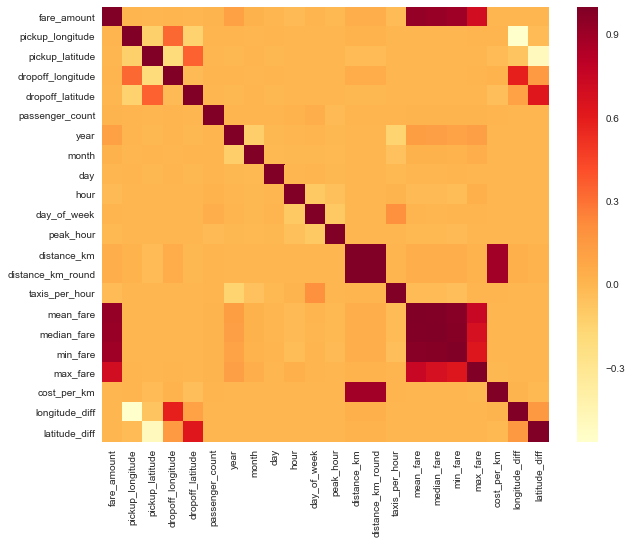

In [35]:
plt.figure(figsize=(10,8))

ax = sns.heatmap(train_df.corr(), square=True, cmap='YlOrRd')
ax.set_aspect('auto')

plt.show()

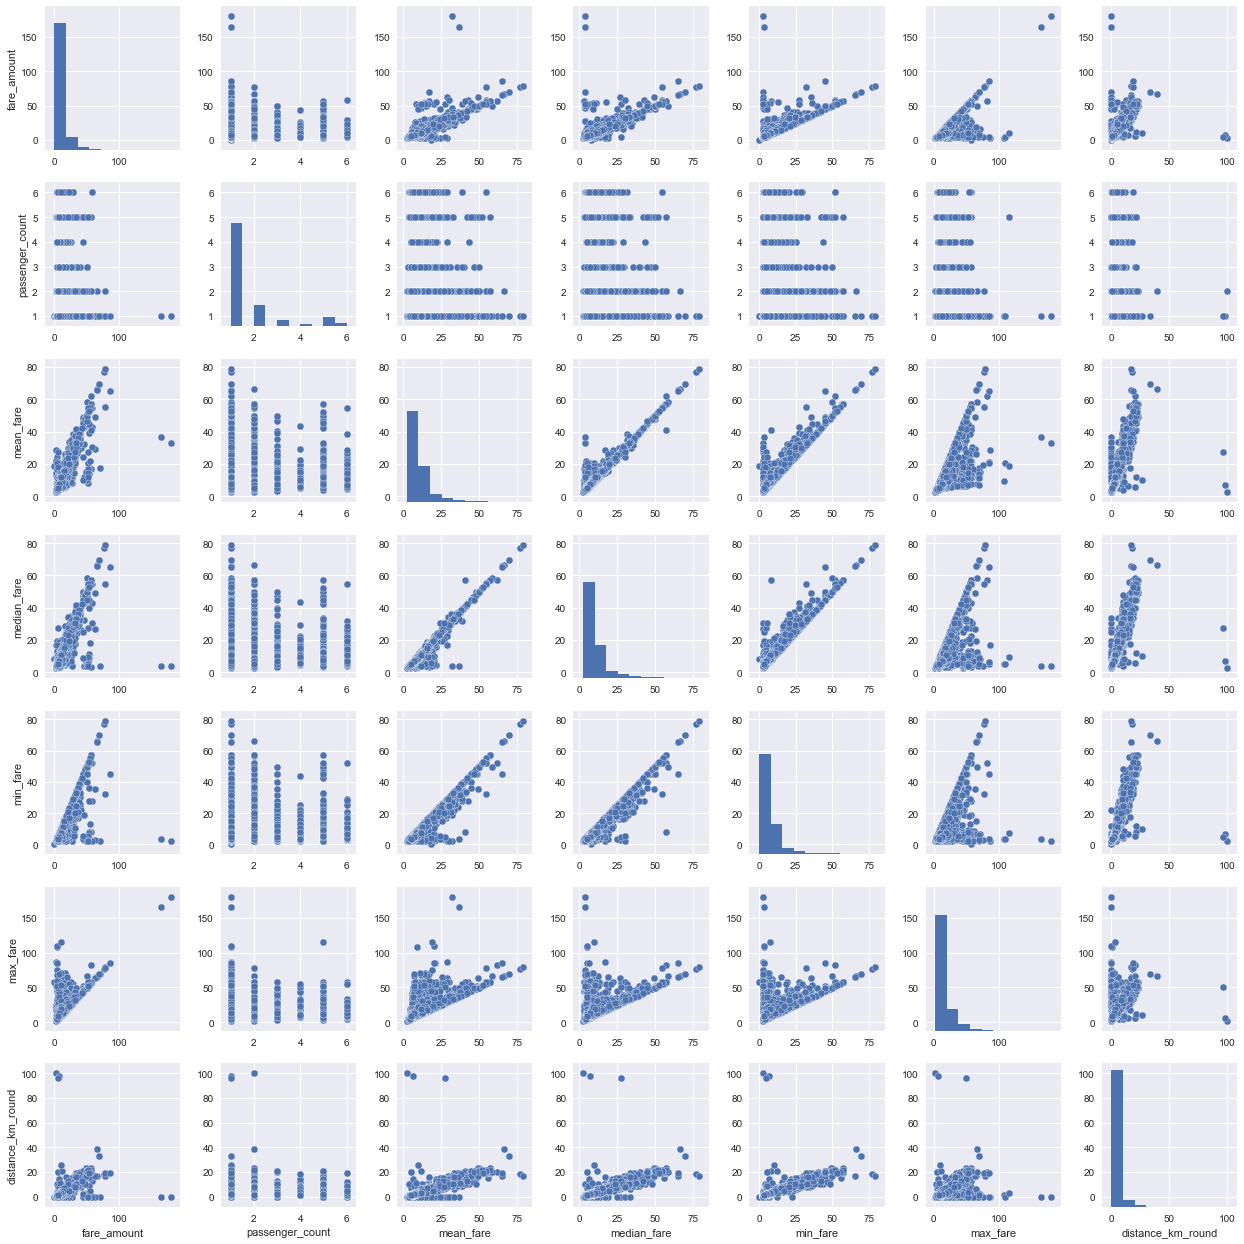

In [36]:
train_subset = train_df[:5000]
sns.pairplot(train_subset, vars=['fare_amount','passenger_count','mean_fare','median_fare','min_fare','max_fare','distance_km_round'])
plt.show()

In [37]:
# check feature statistics
pd.set_option('float_format', '{:f}'.format) # prints the entire number instead of x + ye
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,...,distance_km,distance_km_round,taxis_per_hour,mean_fare,median_fare,min_fare,max_fare,cost_per_km,longitude_diff,latitude_diff
count,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000,...,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000,4882706.000000
mean,11.312660,-72.710228,42.522438,-72.707497,42.519543,1.690686,2011.737710,6.268715,15.720531,13.511253,...,4.614829,4.614191,2088.964600,11.301615,10.861936,8.546366,17.013838,0.439632,0.003349,-0.002202
std,9.684735,7.772758,6.863099,7.932261,7.566395,1.306441,1.865131,3.435402,8.684396,6.515809,...,85.681313,85.756889,254.538345,8.987985,9.023960,9.079934,11.648740,12.301396,9.062087,8.094579
min,0.010000,-3426.608887,-3488.079590,-3412.653076,-3488.079590,1.000000,2009.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,117.000000,0.010000,0.010000,0.010000,0.010000,0.000000,-6354.358887,-5501.513672
25%,6.000000,-73.992271,40.736496,-73.991577,40.735523,1.000000,2010.000000,3.000000,8.000000,9.000000,...,1.253000,1.000000,1963.000000,6.340000,6.000000,3.700000,10.500000,0.198020,-0.011505,-0.014023
50%,8.500000,-73.982094,40.753326,-73.980598,40.753834,1.000000,2012.000000,6.000000,16.000000,14.000000,...,2.153000,2.000000,2125.000000,8.538095,8.100000,5.500000,13.700000,0.265487,0.000877,0.000000
75%,12.500000,-73.968292,40.767529,-73.965294,40.768398,2.000000,2013.000000,9.000000,23.000000,19.000000,...,3.914000,4.000000,2277.000000,12.385715,11.900000,8.900000,18.900000,0.342857,0.013885,0.014297
max,952.000000,3439.425537,2977.030518,3457.622314,3345.917236,7.000000,2015.000000,12.000000,31.000000,23.000000,...,19108.796875,19109.000000,2795.000000,495.000000,495.000000,495.000000,952.000000,3024.390381,5472.153320,4346.694336


* Hypothesis: Trip distance affects the price

In [38]:
# plt.figure(figsize=(14,8))

# plt.scatter(x=train_df['distance_km'], y=train_df['fare_amount'])
# plt.xlabel("Trip Distance (km)")
# plt.ylabel("Fare Amount")
# plt.title("Trip Distance vs Fare Amount")
# plt.show()

In [39]:
display(train_df[train_df['distance_km'] > 200].sort_values(by=['distance_km']).head())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,distance_km,distance_km_round,taxis_per_hour,mean_fare,median_fare,min_fare,max_fare,cost_per_km,longitude_diff,latitude_diff
3237504,18.500000,2010-04-17 00:03:00+00:00,-73.886192,42.591679,-73.974876,40.788563,1,2010,4,17,...,200.632004,201,2367.000000,18.500000,18.500000,18.500000,18.500000,10.864865,-0.088684,-1.803116
361498,4.900000,2012-04-18 15:38:00+00:00,-76.349998,40.773037,-73.946983,40.780136,1,2012,4,18,...,202.337997,202,2300.000000,4.900000,4.900000,4.900000,4.900000,41.224487,2.403015,0.007099
3952668,11.500000,2012-10-12 10:11:00+00:00,-73.981720,40.777706,-73.963913,42.599998,1,2012,10,12,...,202.634995,203,2442.000000,11.500000,11.500000,11.500000,11.500000,17.652174,0.017807,1.822292
4623510,9.000000,2012-12-31 01:43:00+00:00,-71.349998,40.739899,-73.978539,40.729866,2,2012,12,31,...,221.466003,221,1951.000000,9.000000,9.000000,9.000000,9.000000,24.555555,-2.628540,-0.010033
2203886,8.100000,2012-08-01 14:58:00+00:00,-71.283333,40.755646,-73.989090,40.749943,1,2012,8,1,...,227.908005,228,2014.000000,8.100000,8.100000,8.100000,8.100000,28.148148,-2.705757,-0.005703


Traffic hours might affect the price;

In [40]:
# plt.figure(figsize=(14,8))

# plt.scatter(x=train_df['taxis_per_hour'], y=train_df['fare_amount'])
# plt.xlabel("Traffic (taxis)")
# plt.ylabel("Fare Amount")
# plt.title("Number of Rides vs Fare Amount")
# plt.show()

# 5. Model Training

In [41]:
target = train_df[['fare_amount']]

df = train_df.drop(['fare_amount', 'pickup_datetime'], axis=1)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_regression, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from itertools import compress

X = df
y = target.values.ravel()

# Split X,y into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('>>> Train/Test Split done!')

# Create the 1st model using GradientBoostingRegressor
# gbr_model = GradientBoostingRegressor(n_estimators=25, random_state=7, learning_rate=0.1, max_depth=7) # with log1p/expm1: 0.514
# gbr_model.fit(X_train, np.log1p(y_train))
# print('>>> Model1 Training done!')

# Create the 2nd model using RandomForestRegressor
rfr_model = RandomForestRegressor(n_jobs=6, n_estimators=25, max_features=len(df.columns), max_depth=25, min_samples_split=3, min_samples_leaf=3, random_state=42)
rfr_model.fit(X_train, np.log1p(y_train))
print('>>> Model2 Training done!')

>>> Train/Test Split done!
>>> Model2 Training done!


# 6. Model Evaluation


>>> RMSE Score: 1.9132067975650862 



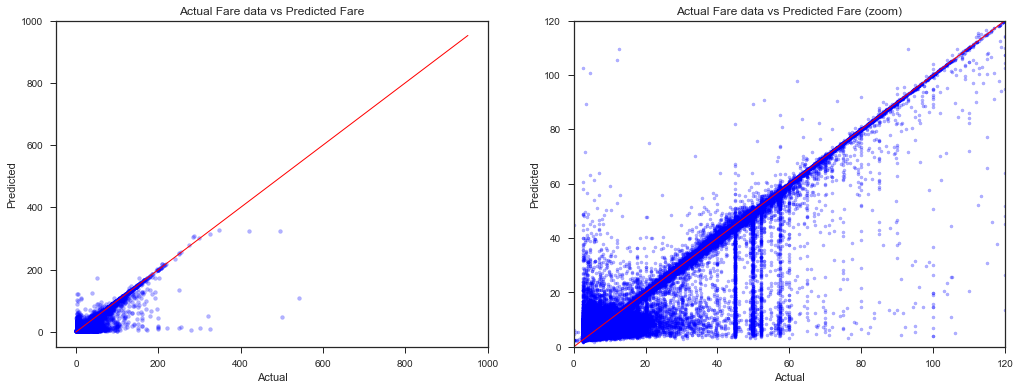

In [43]:
from lib import gfx  # gfx is another local module under the 'lib' directory
from sklearn import metrics
from math import sqrt

# The prediction is calculated as the arithmetic mean of both model's predictions
# gbr_fare = np.expm1(gbr_model.predict(X_test))  # model 1
rfr_fare = np.expm1(rfr_model.predict(X_test))   # model 2

# y_pred = (gbr_visitors + rfr_visitors) / 2
# y_pred = gbr_fare
y_pred = rfr_fare

rmse_score = sqrt(metrics.mean_squared_error(y_test, y_pred))
print('\n>>> RMSE Score:', rmse_score, '\n') # 3.84501 (2.3885)

# Plot Actual FARE data against Predicted fare
gfx.plot_actual_vs_predicted(y, y_test, y_pred)

In [44]:
from datetime import timedelta

elapsed_time = (time.time() - start_time)
print('>>> Runtime:', str(timedelta(seconds=elapsed_time)))

>>> Runtime: 0:17:27.483744


RMSE Score: 1.909 (no night, no holiday, no_peak_hour)